---

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch import nn

from time import time
from tqdm import tqdm

from sklearn.metrics import roc_auc_score, average_precision_score,auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, auc, precision_recall_curve
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.utils import shuffle

import pandas as pd
import os
import sys

seed = 1234
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

device = torch.device('cuda' if (torch.cuda.is_available()) else 'cpu')

from load_data import get_CreditCard

In [2]:
def meanAUC_PRAUC(auc_list, pr_list, name, SPACE_AUC, SPACE_AUPRC):
    print('AUC:')
    print(auc_list)
    print('**************')
    print('PR AUC:')
    print(pr_list)
    print('**************')
    
    
    AUC_Frame = pd.DataFrame(auc_list, columns = [name])
    PR_AUC_Frame = pd.DataFrame(pr_list, columns = [name])
    
    AU_NAME = f'{name}.csv'
    
    AUC_Frame.to_csv(os.path.join(SPACE_AUC, AU_NAME), index=False)
    PR_AUC_Frame.to_csv(os.path.join(SPACE_AUPRC, AU_NAME), index=False)
    
    AUC_Frame = list(AUC_Frame[name])

    N = len(AUC_Frame)
    mean_auc = np.mean(AUC_Frame)
    std_auc = np.std(AUC_Frame)
    std_error = std_auc / (np.sqrt(N))

    ci = 1.96 * std_error
    lower_bound = mean_auc - ci
    upper_bound = mean_auc + ci
    
    print('AUC')
    print(f'{mean_auc:.2f} +/- {ci:.2f}')
    print(f'95% confidence level, average auc would be between {lower_bound:.2f} and {upper_bound:.2f}')
    print('**************')
    
    PR_AUC_Frame = list(PR_AUC_Frame[name])

    N = len(PR_AUC_Frame)
    mean_auc = np.mean(PR_AUC_Frame)
    std_auc = np.std(PR_AUC_Frame)
    std_error = std_auc / (np.sqrt(N))

    ci = 1.96 * std_error
    lower_bound = mean_auc - ci
    upper_bound = mean_auc + ci
    
    print('PR AUC')
    print(f'{mean_auc:.2f} +/- {ci:.2f}')
    print(f'95% confidence level, average auc would be between {lower_bound:.2f} and {upper_bound:.2f}')

In [6]:
def plotLoss(losses, d_losses_val, p_true, p_fake, rec_errors, kldes, real_scores, fake_scores, i, DATASET, show = False):
    num_epochs = len(losses)
    
    plt.figure()
    plt.xlim(0, num_epochs + 1)
    plt.plot(range(1, num_epochs + 1), losses[:num_epochs], label='$\mathcal{L}$')  
    
    plt.legend(loc = 'lower right', bbox_to_anchor=(.8, 0.3, 0.5, 0.5))
    
    if show:
        plt.show()
    else:
        plt.savefig(f'./images/{i}_losses_{DATASET}.pdf')
    
    plt.figure()
    plt.xlim(0, num_epochs + 1)
    
    plt.plot(range(1, num_epochs + 1), p_true[:num_epochs], 'y', label=r'$\mathbb{E}_{x}\left[\log p_{\theta} (1|x)\right]$')
    plt.plot(range(1, num_epochs + 1), p_fake[:num_epochs], 'green', label=r'$\mathbb{E}_{\tilde{x}}\left[\log p(0|\tilde{x})\right]$')
    plt.plot(range(1, num_epochs + 1), rec_errors[:num_epochs], 'magenta', label=r'$\mathbb{E}_{\tilde{x}}\left[\log p_{\theta} (x|\tilde{x})\right]$')     
    plt.plot(range(1, num_epochs + 1), kldes[:num_epochs], 'red', label=r'$\mathbb{KLD}$') 

    plt.yscale('log')
    plt.legend(loc = 'lower right', bbox_to_anchor=(.9, 0.3, 0.5, 0.5))
    
    if show:
        plt.show()
    else:
        plt.savefig(f'./images/{i}_gen_loss_{DATASET}.pdf')  
    
    plt.figure()
    plt.xlim(0, num_epochs + 1)
    plt.ylim(0, 1)
    plt.plot(range(1, num_epochs + 1), fake_scores[:num_epochs], label='fake score')
    plt.plot(range(1, num_epochs + 1), real_scores[:num_epochs], label='real score')    

    plt.legend(loc = 'lower right', bbox_to_anchor=(.8, 0.3, 0.5, 0.5))
    
    if show:
        plt.show()
    else:
        plt.savefig(f'./images/{i}_score_{DATASET}.pdf') 

def generate_labels(size,pflip,lb,ub,step,decay=.9995,up=True): #decay=.99995
    
    if up:
        lb = ub - (ub-lb)*((decay)**step)
    else:
        ub = lb + (ub-lb)*((decay)**step)
    pflip = pflip*((decay)**step)
    
    y = np.random.uniform(lb, ub,size)   

    sf = int(pflip*size)    
    if sf > 0:
        y[:sf] = 1- y[:sf]
        np.random.shuffle(y)
    
    return torch.FloatTensor(y)


class Generator(nn.Module):
    def __init__(self, nf_in = 121, nf_out = 32, z_dim = 16):
        super(Generator, self).__init__()

        self.nf_in = nf_in
        self.nf_out = nf_out
        self.z_dim = z_dim

        self.encoder = nn.Sequential(
            nn.Linear(self.nf_in, self.nf_out * 2), 
            nn.BatchNorm1d(self.nf_out * 2, track_running_stats = False),
            nn.LeakyReLU(0.2),
            
            nn.Linear(self.nf_out * 2, self.nf_out),
            nn.BatchNorm1d(self.nf_out, track_running_stats = False),
            nn.LeakyReLU(0.2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(self.nf_out, self.nf_out * 2),
            nn.BatchNorm1d(self.nf_out * 2, track_running_stats = False),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(self.nf_out * 2, self.nf_in)
        )

        self.fc1 = nn.Linear(self.nf_out, self.nf_out)
        self.fc21 = nn.Linear(self.nf_out, self.z_dim)
        self.fc22 = nn.Linear(self.nf_out, self.z_dim)

        self.fc3 = nn.Linear(self.z_dim, self.nf_out)
        self.fc4 = nn.Linear(self.nf_out, self.nf_out)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        
        self.init_weights()  
        
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.randn_like(std)
        z = mu + std * eps
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc21(h), self.fc22(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        conv = self.encoder(x)
        h = self.fc1(conv)
        
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        h = self.relu(self.fc3(z))
        deconv_input = self.fc4(h)
        
        return self.decoder(deconv_input)
    
    def gumbel(self, logits, t):
        return gumbel_softmax(logits, t)

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        logits = self.decode(z)
        sampled_data = self.sigmoid(logits)
        return logits, mu, logvar, sampled_data
    
class Discriminator(nn.Module):

    def __init__(self, nc = 121, nf_out = 16, nout = 128):
        super(Discriminator, self).__init__()
        
        self.nc = nc
        self.nf_out = nf_out
        self.nout = nout
        
        self.main = nn.Sequential(
            # features extractor
            nn.Linear(self.nc, self.nout),
            nn.BatchNorm1d(self.nout, track_running_stats = False),
            nn.LeakyReLU(0.2),

            nn.Linear(self.nout, self.nout * 2),
            nn.BatchNorm1d(self.nout * 2, track_running_stats = False),
            nn.LeakyReLU(0.2),

            nn.Linear(self.nout * 2, self.nout * 4),
            nn.BatchNorm1d(self.nout * 4, track_running_stats = False),
            nn.LeakyReLU(0.2),

            # classifier
            nn.Linear(self.nout * 4, self.nout),
            nn.BatchNorm1d(self.nout, track_running_stats = False),
            nn.ReLU(),

            nn.Linear(self.nout, self.nf_out * 4),
            nn.BatchNorm1d(self.nf_out * 4, track_running_stats = False),
            nn.ReLU(),

            nn.Dropout(0.2),
            nn.Linear(self.nf_out * 4, self.nf_out * 2),
            nn.ReLU(),

            nn.Dropout(0.2),
            nn.Linear(self.nf_out * 2, self.nf_out),
            nn.ReLU(),

            nn.Dropout(0.2),
            nn.Linear(self.nf_out, 1),
            nn.Sigmoid()
        )
        
        self.init_weights()  
        
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    
    def forward(self, x):
        x = self.main(x)
        return x.flatten()
    
    
class Loss(nn.Module):
    def __init__(self, device):
        super(Loss, self).__init__()
        self.device = device
        
        self.bce = nn.BCELoss() 
        self.mse = nn.MSELoss()
        self.cel = nn.CrossEntropyLoss()
        
        
    def KLD(self,z_mean, z_logvar):
        return torch.mean(0.5 * (-0.5 * z_logvar + torch.exp(0.5 * z_logvar) + z_mean ** 2))
        

    def reconstruction(self, true_data, sampled_data):
        return self.mse(true_data, sampled_data)
        
    def forward(self, true_data, sampled_data, z_mean, z_logvar, true_pred, fake_pred, step, alpha = 1):
        bs = true_pred.size(0)
        
        y_real = generate_labels(bs,0.3,0.7,1., step, up=True).to(self.device)
        y_fake = generate_labels(bs,0.3,0.,0.3, step, up=False).to(self.device)
        
        log_p_true = self.bce(true_pred, y_real)
        log_p_fake = self.bce(fake_pred, y_fake)
        
        reconstruction = self.reconstruction(true_data, sampled_data)
        kld = self.KLD(z_mean, z_logvar)
        
        return log_p_true + log_p_fake + alpha*reconstruction + kld, log_p_true, log_p_fake, reconstruction, kld

    
class AADNet(nn.Module):
    def __init__(self, device, nc):
        super(AADNet, self).__init__()
        self.device = device
        self.nc = nc

        self.D = Discriminator(nc = self.nc).to(self.device)
        self.G = Generator(nf_in = self.nc).to(self.device)

        self.optimizer = torch.optim.Adam([
            {'params': self.D.parameters(), 'lr': 1e-4},
            {'params': self.G.parameters(), 'lr': 1e-4}
        ])
        
        self.loss = Loss(self.device)
        
        self.temperature = 1
        self.anneal = 0.9995
        
        self.criterion = nn.BCELoss()

    
    def anneal_temp(self, lowerbound=1e-5):
        if self.temperature > lowerbound:
            self.temperature = self.temperature*self.anneal
            
            
    def evaluation(self, test_loader):
        self.D.eval()
        
        d_l = []
        i = 0
        
        for batch, label in test_loader:
            batch = batch.to(self.device)
            label = label.to(self.device)
            
            with torch.no_grad():
                y_pred = self.D(batch)
                
                d_loss_batch = self.criterion(y_pred, label)
                
            d_l.append(d_loss_batch.item())
        
        return np.mean(d_l)
    
    def plot_pr_curve(self, precision, recall):
        plt.figure()
        plt.plot(recall, precision, marker='.')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
    
    def pr_auc(self, y_test, y_pred):
        precision, recall, _ = precision_recall_curve(y_test, y_pred)
        auc_score = auc(recall, precision)
        print(f'PR AUC: {auc_score:.2f}')
        self.plot_pr_curve(precision, recall)
        return auc_score
    
    def predict(self, test_loader):
        self.D.eval()
        i = 0
        
        for batch, label in test_loader:
            batch = batch.to(self.device)
            label = label.to(self.device)
            
            with torch.no_grad():
                y_pred = self.D(batch)
                
            if i == 0:
                prediction = y_pred.cpu().round()
                y_true = label.cpu()
                yP = y_pred.cpu()
            else:
                prediction = torch.cat((prediction, y_pred.cpu().round()))
                y_true = torch.cat((y_true, label.cpu()))
                yP = torch.cat((yP, y_pred.cpu()))
                
            i += 1
            
        return prediction, y_true, yP
        
        
    def train(self, data_loader, test_loader, name_d, name_g, batch_size = 32, num_epochs = 10, step = 10, lowerbnd=5e-15, num_q_steps = 1, num_g_steps = 1):
        
        losses = np.zeros(num_epochs)
        p_true = np.zeros(num_epochs)
        p_fake = np.zeros(num_epochs)
        rec_errors = np.zeros(num_epochs)
        kldes = np.zeros(num_epochs)
        real_scores = np.zeros(num_epochs)
        fake_scores = np.zeros(num_epochs)
        
        d_losses_val = np.zeros(num_epochs)
        
        self.temperature = 1.
        
        total_steps = (len(data_loader.dataset) // batch_size) #*num_epochs
        print("[INFO] Starting training phase...")
        start = time()
        
        minloss = np.Inf
        
        try:
            
            step_count = 0
            for epoch in range(num_epochs):
                self.D.train()
                self.G.train()
                i = 0
                for batch in data_loader:
                    
                    step_count += 1
                    batch = batch.to(self.device)

                    logits, z_mean, z_logvar, sampled_data = self.G(batch)
                    
                    true_pred = self.D(batch)
                    fake_pred = self.D(sampled_data)
                    
                    _loss, log_p_true, log_p_fake, reconstruction, kld = self.loss(batch, logits, z_mean, z_logvar, true_pred, fake_pred, step_count)
                    _loss.backward()
                    self.optimizer.step()
                    
                    
                    losses[epoch] = losses[epoch]*(i/(i+1.)) + _loss.item()*(1./(i+1.))
                    rec_errors[epoch] = rec_errors[epoch]*(i/(i+1.)) + reconstruction.item()*(1./(i+1.)) 
                    kldes[epoch] = kldes[epoch]*(i/(i+1.)) + kld.item()*(1./(i+1.))
                    p_true[epoch] = p_true[epoch]*(i/(i+1.)) + log_p_true.item()*(1./(i+1.))
                    p_fake[epoch] = p_fake[epoch]*(i/(i+1.)) + log_p_fake.item()*(1./(i+1.))
                    
                    real_scores[epoch] = real_scores[epoch]*(i/(i+1.)) + true_pred.mean().item()*(1./(i+1.))
                    fake_scores[epoch] = fake_scores[epoch]*(i/(i+1.)) + fake_pred.mean().item()*(1./(i+1.))


                    # Anneal the temperature along with training steps
                    self.anneal_temp(lowerbnd)
                    
                    i += 1
                    
                if losses[epoch] < minloss:    
                    minloss = losses[epoch]
                    torch.save(self.D.state_dict(), os.path.join(SPACE_MODELS, name_d))
                    torch.save(self.G.state_dict(), os.path.join(SPACE_MODELS, name_g))
                
                dLossVal = self.evaluation(test_loader)
                
                d_losses_val[epoch] = dLossVal
               
                sys.stdout.write("\r" + 'Epoch [{:>3}/{}] | loss: {:.4f} ({:.4f}, {:.4f}, {:.4f}, {:.4f}) | D(x): {:.2f} | D(G(x)): {:.2f} |  d_loss_val: {:.4f} |'
                              .format(epoch+1, num_epochs, losses[epoch], p_true[epoch], p_fake[epoch], rec_errors[epoch], kldes[epoch], real_scores[epoch], fake_scores[epoch], d_losses_val[epoch]))
                sys.stdout.flush()
                
        
        except KeyboardInterrupt:
            print('-' * 89)
            print('[INFO] Exiting from training early')
        print(f'\n[INFO] Training phase... Elapsed time: {(time() - start):.0f} seconds\n')
        return losses[:epoch], p_true[:epoch],p_fake[:epoch], rec_errors[:epoch], kldes[:epoch], real_scores[:epoch], fake_scores[:epoch], d_losses_val[:epoch]
    

In [7]:
batch_size = 1024

WORK_SPACE = '../Dataset'

SPACE_MODELS = './models'
SPACE_AUC = './auc'
SPACE_AUPRC = './auprc'

for n in (SPACE_MODELS, SPACE_AUC, SPACE_AUPRC):
    if not os.path.exists(n):
        os.mkdir(n)

DATASET = 'CreditCard'
FILE = 'creditcard.csv'

PATH = os.path.join(WORK_SPACE, DATASET, FILE)

In [8]:
dataset = get_CreditCard(PATH, seed, show=True)

284315 normal records, 492 anormal records
-----------------------------------------------------------------------------------------
There are 227846 records in training set
Training set is composed by 227846 normal records and 0 abnormal records
-----------------------------------------------------------------------------------------
There are 14240 records in validation set
Validation set is composed by 14117 normal records and 123 abnormal records
-----------------------------------------------------------------------------------------
There are 42721 records in test set
Test set is composed by 42352 normal records and 369 abnormal records


#### Mean AUC and standard deviation after seven runs

Iteration: 1
[INFO] Starting training phase...
Epoch [100/100] | loss: 0.8067 (0.0024, 0.0097, 0.2608, 0.5337) | D(x): 1.00 | D(G(x)): 0.00 |  d_loss_val: 0.2092 |
[INFO] Training phase... Elapsed time: 841 seconds



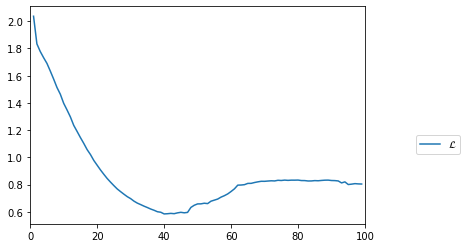

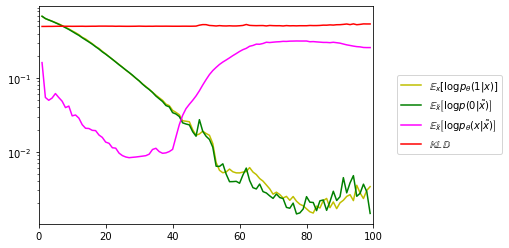

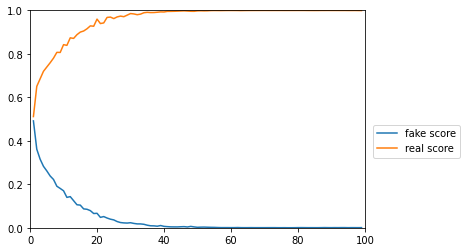

PR AUC: 0.24


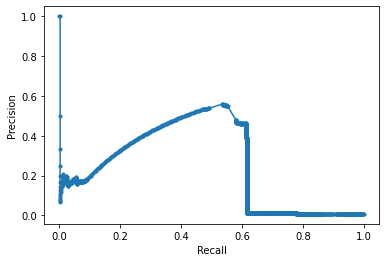

AUC: 0.69
Iteration: 2
[INFO] Starting training phase...
Epoch [100/100] | loss: 2.0336 (0.0063, 0.0014, 1.4252, 0.6007) | D(x): 1.00 | D(G(x)): 0.00 |  d_loss_val: 0.2616 |
[INFO] Training phase... Elapsed time: 838 seconds



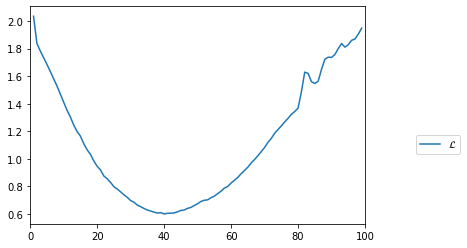

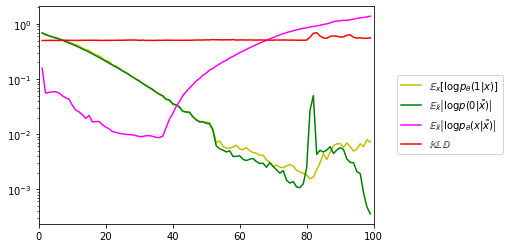

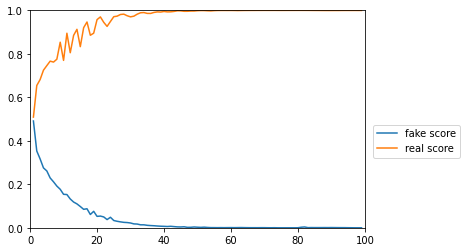

PR AUC: 0.14


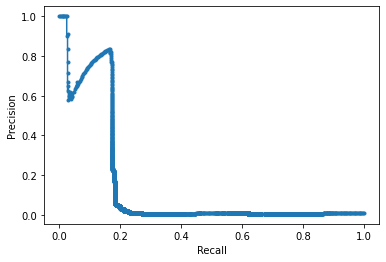

AUC: 0.45
Iteration: 3
[INFO] Starting training phase...
Epoch [100/100] | loss: 2.3743 (0.0057, 0.0019, 1.7950, 0.5716) | D(x): 1.00 | D(G(x)): 0.00 |  d_loss_val: 0.2616 |
[INFO] Training phase... Elapsed time: 839 seconds



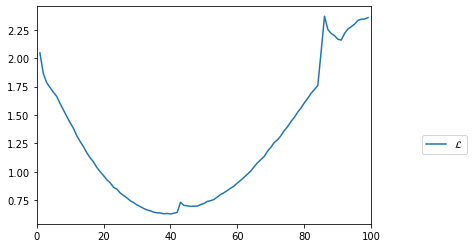

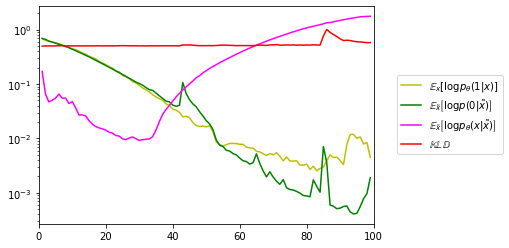

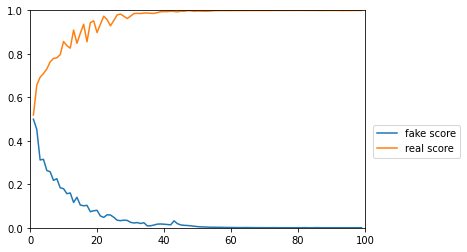

PR AUC: 0.43


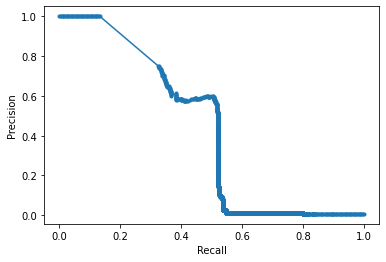

AUC: 0.66
Iteration: 4
[INFO] Starting training phase...
Epoch [100/100] | loss: 0.8914 (0.0060, 0.0032, 0.3492, 0.5330) | D(x): 1.00 | D(G(x)): 0.00 |  d_loss_val: 0.2091 |
[INFO] Training phase... Elapsed time: 809 seconds



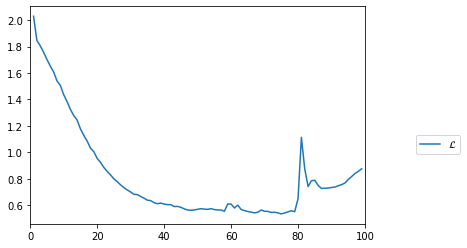

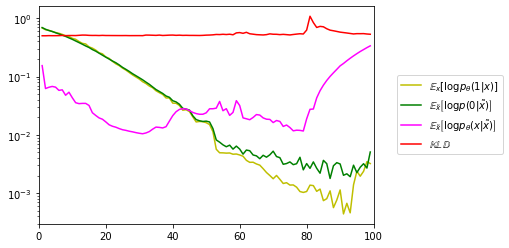

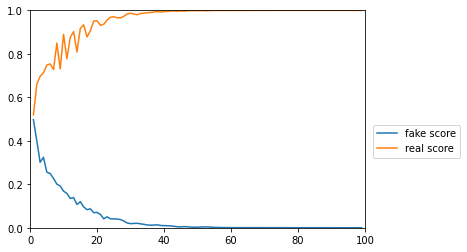

PR AUC: 0.79


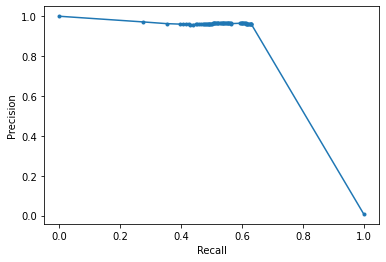

AUC: 0.82
Iteration: 5
[INFO] Starting training phase...
Epoch [100/100] | loss: 1.7986 (0.3105, 0.2430, 0.6562, 0.5889) | D(x): 0.90 | D(G(x)): 0.11 |  d_loss_val: 0.3458 |
[INFO] Training phase... Elapsed time: 812 seconds



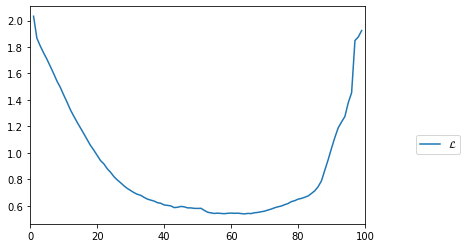

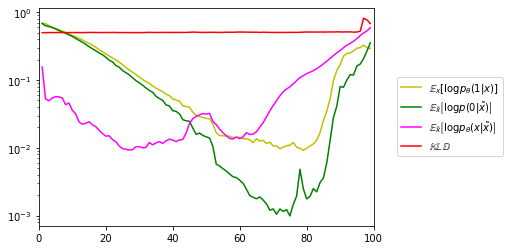

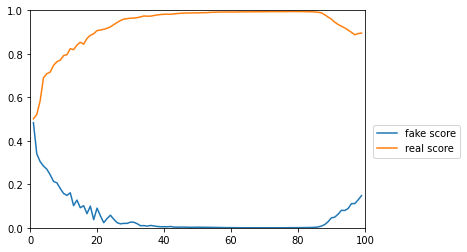

PR AUC: 0.24


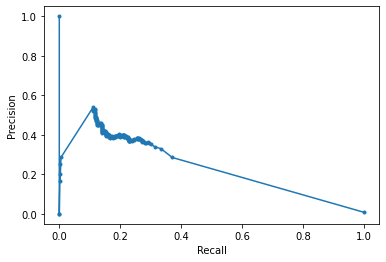

AUC: 0.68
Iteration: 6
[INFO] Starting training phase...
Epoch [100/100] | loss: 0.5577 (0.0006, 0.0002, 0.0449, 0.5119) | D(x): 1.00 | D(G(x)): 0.00 |  d_loss_val: 0.8022 |
[INFO] Training phase... Elapsed time: 849 seconds



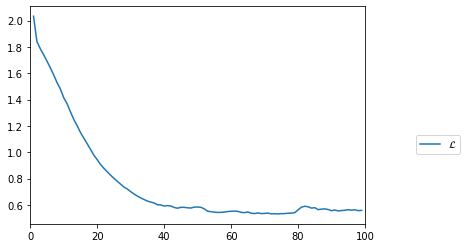

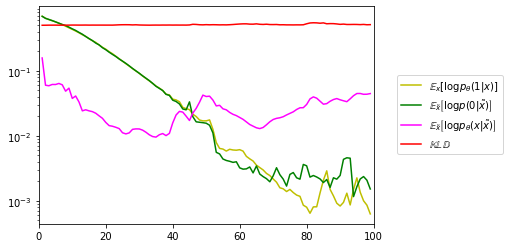

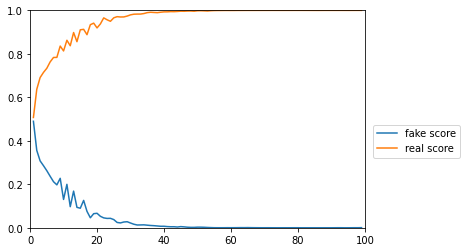

PR AUC: 0.53


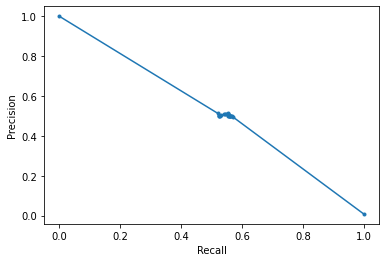

AUC: 0.78
Iteration: 7
[INFO] Starting training phase...
Epoch [100/100] | loss: 0.5683 (0.0047, 0.0002, 0.0166, 0.5468) | D(x): 1.00 | D(G(x)): 0.00 |  d_loss_val: 0.2363 |
[INFO] Training phase... Elapsed time: 856 seconds



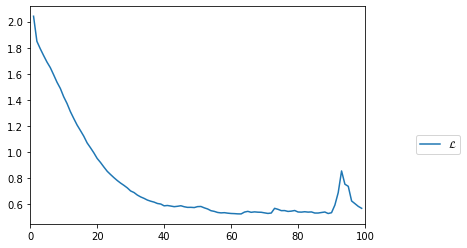

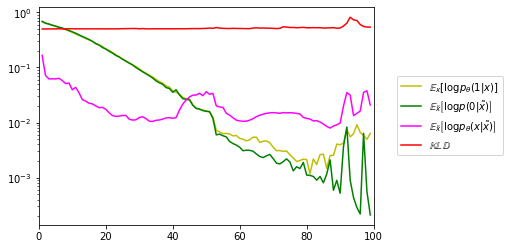

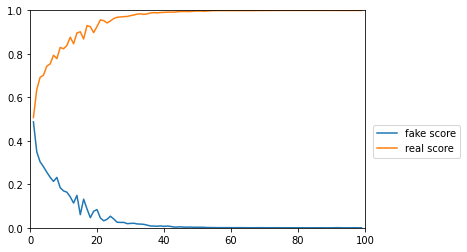

PR AUC: 0.21


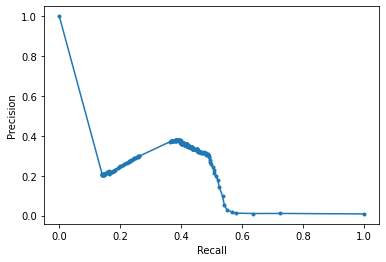

AUC: 0.70
Iteration: 8
[INFO] Starting training phase...
Epoch [100/100] | loss: 1.2083 (0.0327, 0.0010, 0.6458, 0.5288) | D(x): 1.00 | D(G(x)): 0.00 |  d_loss_val: 0.2544 |
[INFO] Training phase... Elapsed time: 770 seconds



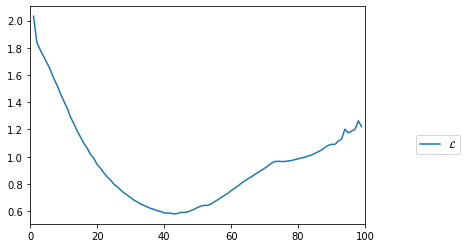

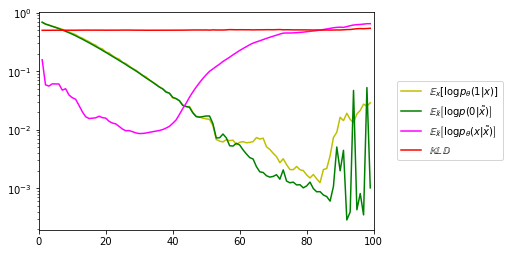

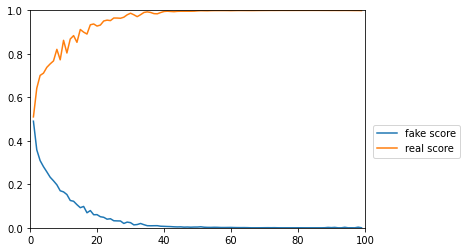

PR AUC: 0.10


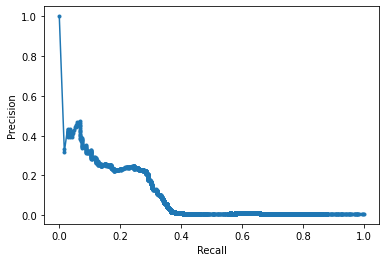

AUC: 0.53
Iteration: 9
[INFO] Starting training phase...
Epoch [100/100] | loss: 2.6191 (0.0145, 0.0033, 2.0910, 0.5102) | D(x): 1.00 | D(G(x)): 0.00 |  d_loss_val: 0.2594 |
[INFO] Training phase... Elapsed time: 699 seconds



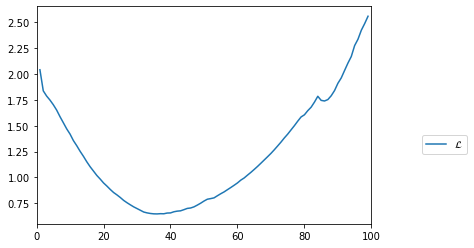

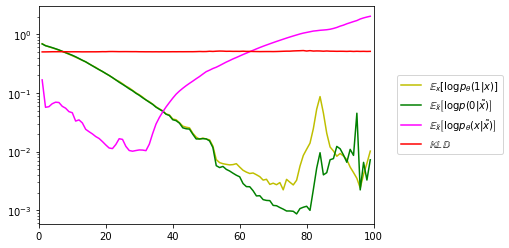

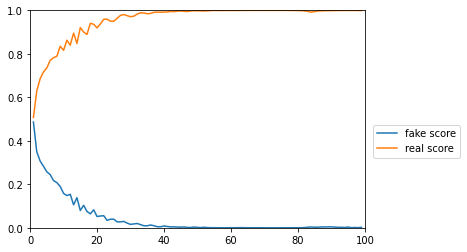

PR AUC: 0.28


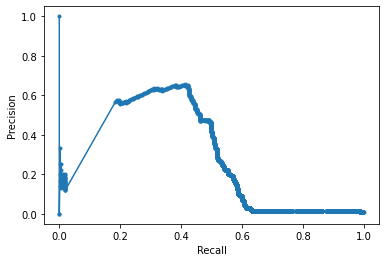

AUC: 0.81
Iteration: 10
[INFO] Starting training phase...
Epoch [100/100] | loss: 0.5285 (0.0038, 0.0022, 0.0123, 0.5101) | D(x): 1.00 | D(G(x)): 0.00 |  d_loss_val: 0.2198 |
[INFO] Training phase... Elapsed time: 717 seconds



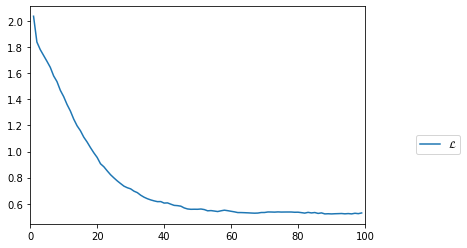

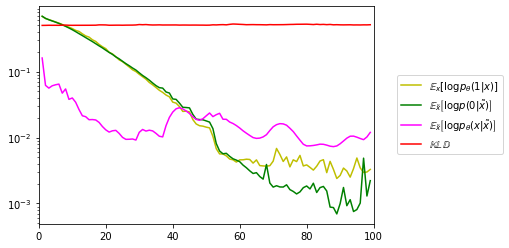

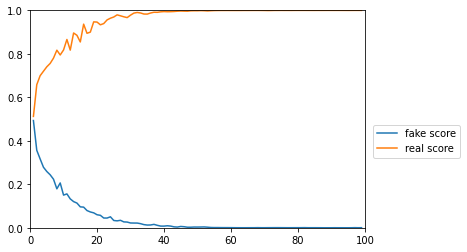

PR AUC: 0.70


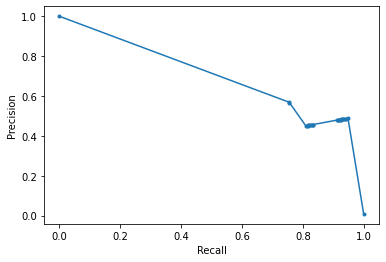

AUC: 0.97
Iteration: 11
[INFO] Starting training phase...
Epoch [100/100] | loss: 0.5398 (0.0036, 0.0032, 0.0070, 0.5261) | D(x): 1.00 | D(G(x)): 0.00 |  d_loss_val: 0.3073 |
[INFO] Training phase... Elapsed time: 733 seconds



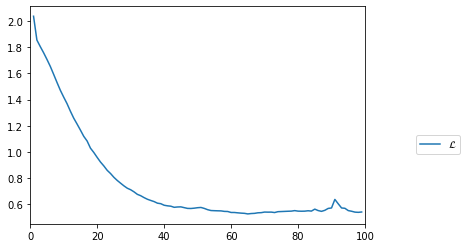

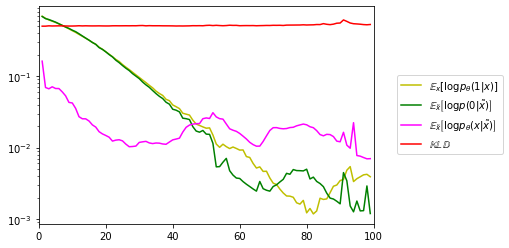

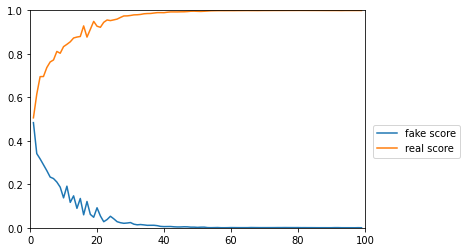

PR AUC: 0.37


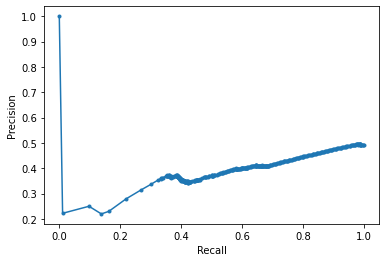

AUC: 0.99
Iteration: 12
[INFO] Starting training phase...
Epoch [100/100] | loss: 0.6115 (0.0299, 0.0004, 0.0452, 0.5360) | D(x): 1.00 | D(G(x)): 0.00 |  d_loss_val: 0.2808 |
[INFO] Training phase... Elapsed time: 798 seconds



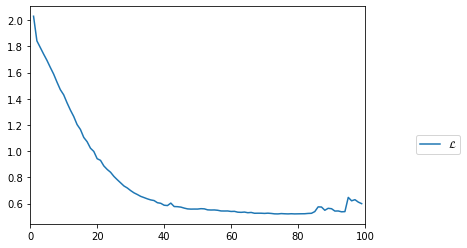

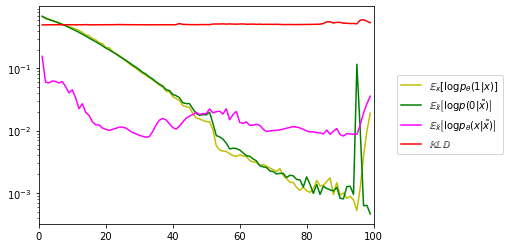

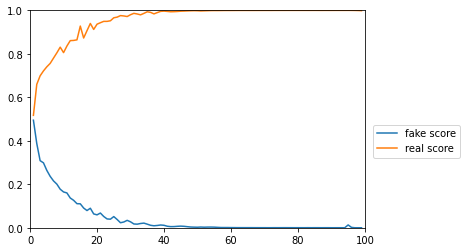

PR AUC: 0.35


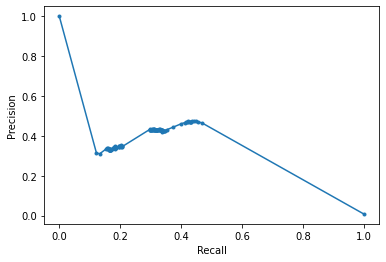

AUC: 0.73
Iteration: 13
[INFO] Starting training phase...
Epoch [100/100] | loss: 1.1647 (0.0613, 0.0259, 0.5647, 0.5128) | D(x): 1.00 | D(G(x)): 0.00 |  d_loss_val: 0.2616 |
[INFO] Training phase... Elapsed time: 842 seconds



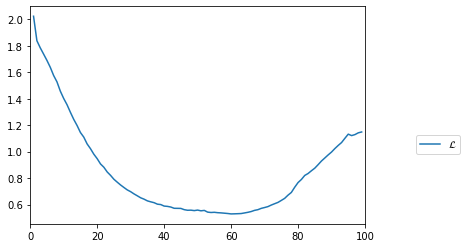

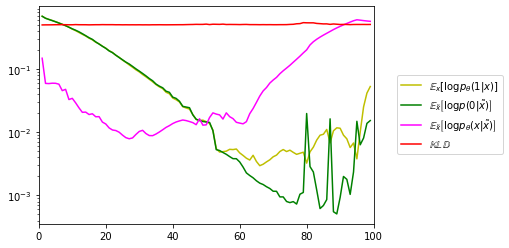

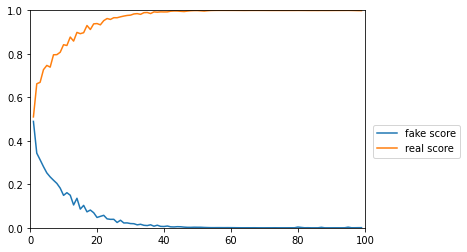

PR AUC: 0.04


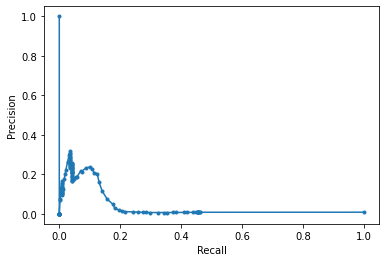

AUC: 0.50
Iteration: 14
[INFO] Starting training phase...
Epoch [100/100] | loss: 1.0747 (0.0219, 0.0030, 0.5260, 0.5239) | D(x): 1.00 | D(G(x)): 0.00 |  d_loss_val: 0.0897 |
[INFO] Training phase... Elapsed time: 848 seconds



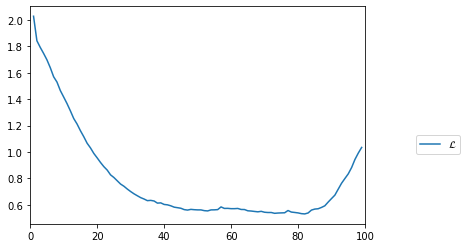

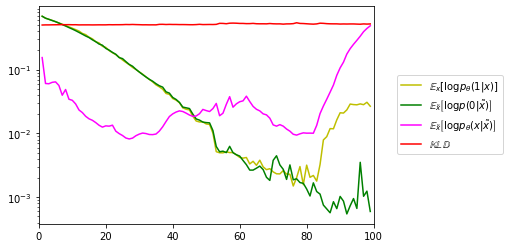

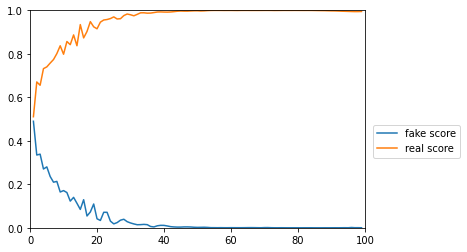

PR AUC: 0.56


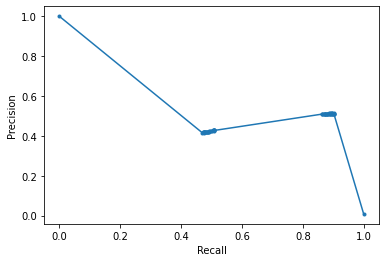

AUC: 0.95
Iteration: 15
[INFO] Starting training phase...
Epoch [100/100] | loss: 0.6169 (0.0049, 0.0021, 0.0495, 0.5604) | D(x): 1.00 | D(G(x)): 0.00 |  d_loss_val: 0.0900 |
[INFO] Training phase... Elapsed time: 954 seconds



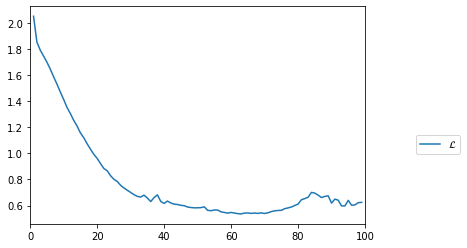

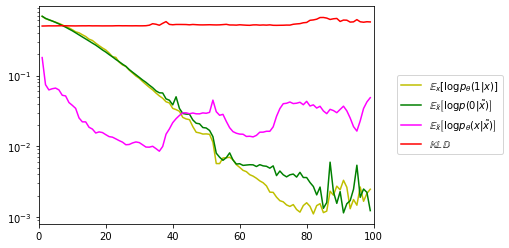

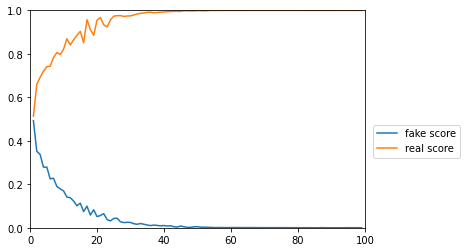

PR AUC: 0.75


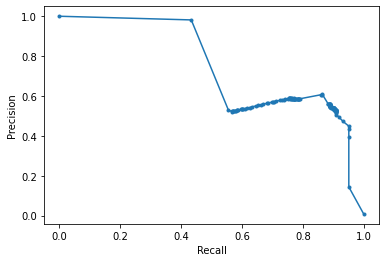

AUC: 0.97
Iteration: 16
[INFO] Starting training phase...
Epoch [100/100] | loss: 2.2557 (0.0239, 0.0346, 1.4468, 0.7504) | D(x): 1.00 | D(G(x)): 0.00 |  d_loss_val: 0.2475 |
[INFO] Training phase... Elapsed time: 1102 seconds



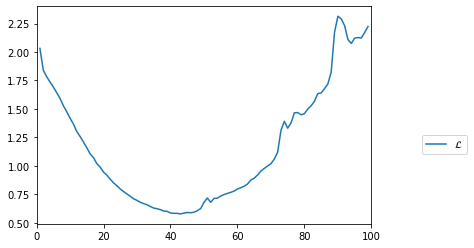

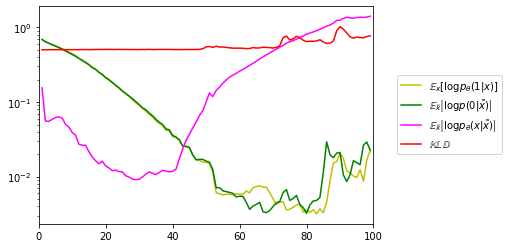

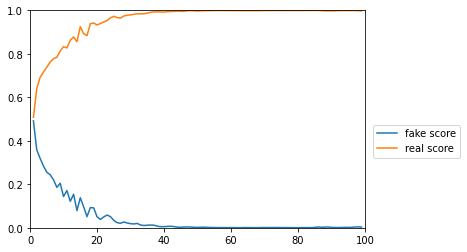

PR AUC: 0.29


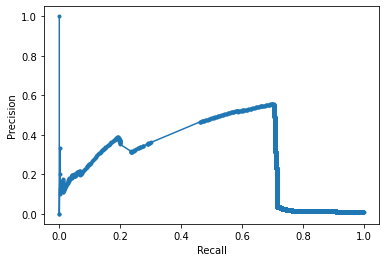

AUC: 0.83
Iteration: 17
[INFO] Starting training phase...
Epoch [100/100] | loss: 1.8362 (0.0043, 0.0128, 1.2741, 0.5450) | D(x): 1.00 | D(G(x)): 0.00 |  d_loss_val: 0.2465 |
[INFO] Training phase... Elapsed time: 1140 seconds



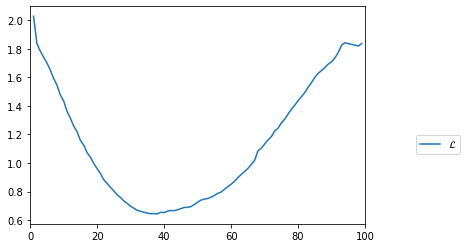

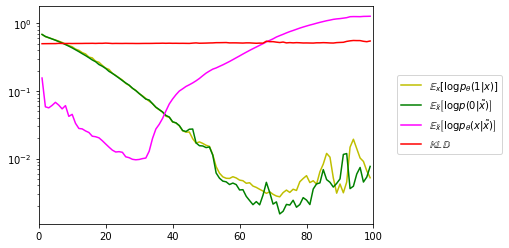

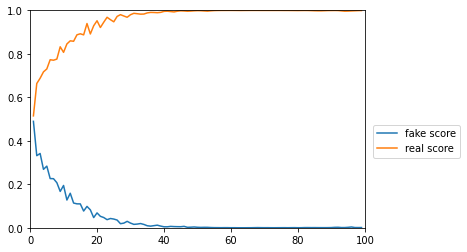

PR AUC: 0.18


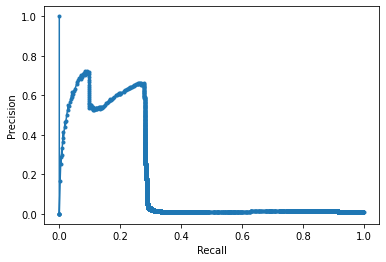

AUC: 0.66
Iteration: 18
[INFO] Starting training phase...
Epoch [100/100] | loss: 0.5566 (0.0026, 0.0012, 0.0214, 0.5314) | D(x): 1.00 | D(G(x)): 0.00 |  d_loss_val: 0.2616 |
[INFO] Training phase... Elapsed time: 1016 seconds



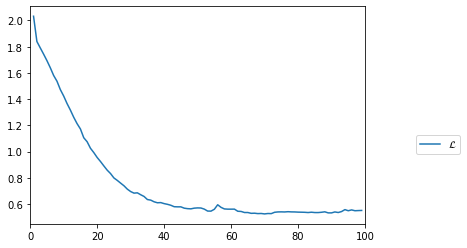

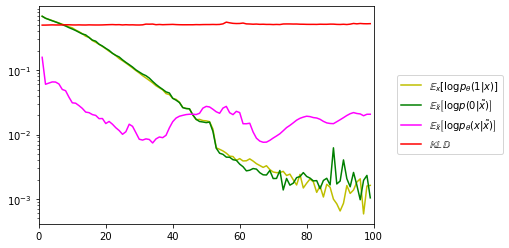

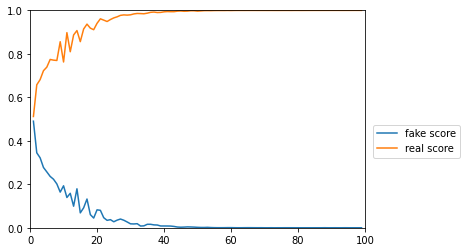

PR AUC: 0.33


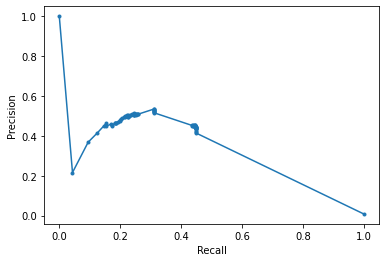

AUC: 0.72
Iteration: 19
[INFO] Starting training phase...
Epoch [100/100] | loss: 1.8984 (0.0700, 0.2072, 1.0233, 0.5979) | D(x): 0.98 | D(G(x)): 0.04 |  d_loss_val: 0.2635 |
[INFO] Training phase... Elapsed time: 1007 seconds



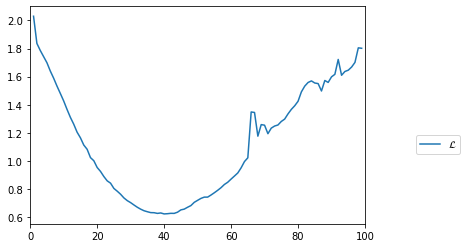

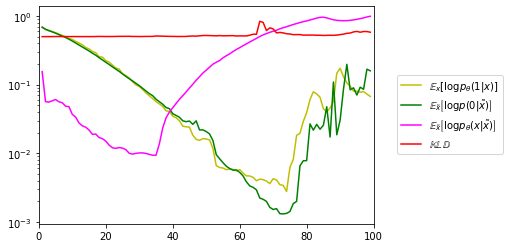

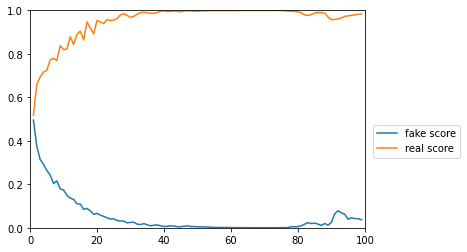

PR AUC: 0.15


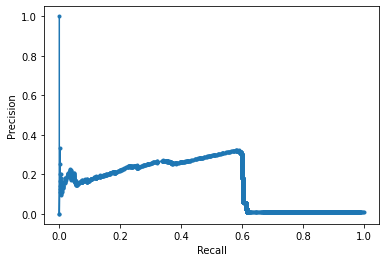

AUC: 0.69
Iteration: 20
[INFO] Starting training phase...
Epoch [100/100] | loss: 1.3976 (0.0039, 0.0103, 0.7651, 0.6183) | D(x): 1.00 | D(G(x)): 0.00 |  d_loss_val: 0.1917 |
[INFO] Training phase... Elapsed time: 1005 seconds



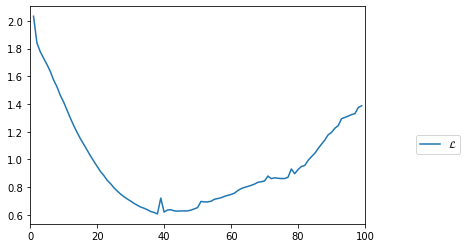

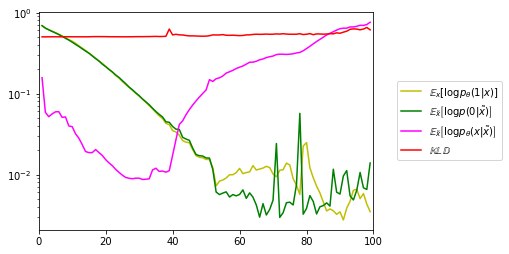

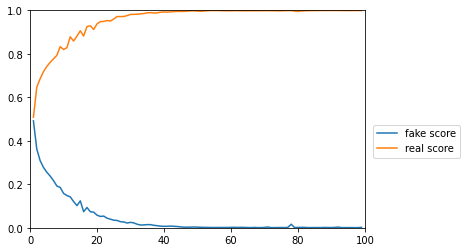

PR AUC: 0.25


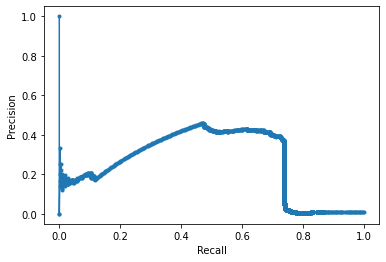

AUC: 0.75


In [9]:
n_runs = 20
auc_list = []
num_epochs = 100
seed = 42
pr_list = []

for i in range(n_runs):
    print(f'Iteration: {i+1}')
    dataset = get_CreditCard(PATH, seed*(i+1), show=False)
    
    train_loader = DataLoader(dataset=torch.FloatTensor(dataset['x_train']), 
                          batch_size = batch_size, shuffle=True, drop_last = True)

    val_dataset = torch.utils.data.TensorDataset(torch.tensor(dataset['x_val']), 
                                              torch.tensor(dataset['y_val'].to_numpy()))
    val_loader = DataLoader(dataset=val_dataset, batch_size = batch_size, shuffle=False)

    test_dataset = torch.utils.data.TensorDataset(torch.tensor(dataset['x_test']), 
                                              torch.tensor(dataset['y_test'].to_numpy()))
    test_loader = DataLoader(dataset=test_dataset, batch_size = batch_size, shuffle=False)
    
    trainer = AADNet(device, dataset['x_train'].shape[1])
    
    NAME_D = f'D_GCN_GE_{DATASET}_{i}.ckpt'
    NAME_G = f'G_GCN_GE_{DATASET}_{i}.ckpt'
    
    losses, p_true, p_fake, rec_errors, kldes, real_scores, fake_scores, d_losses_val = trainer.train(train_loader, val_loader, NAME_D, NAME_G, batch_size = batch_size, num_epochs = num_epochs)
    
    trainer.D.load_state_dict(torch.load(os.path.join(SPACE_MODELS, NAME_D)))
    trainer.G.load_state_dict(torch.load(os.path.join(SPACE_MODELS, NAME_G)))
    
    plotLoss(losses, d_losses_val, p_true, p_fake, rec_errors, kldes, real_scores, fake_scores, i, DATASET, show = True)
    
    prediction, y_true, yP = trainer.predict(test_loader)
    _auc = roc_auc_score(1-y_true, 1-yP)
    pr = trainer.pr_auc(1-y_true, 1-yP)
    print(f'AUC: {_auc:.2f}')
    
    auc_list.append(_auc)
    pr_list.append(pr)

In [10]:
meanAUC_PRAUC(auc_list, pr_list, 'GCN_GE_CreditCard_1', SPACE_AUC, SPACE_AUPRC)

AUC:
[0.689288021516407, 0.45145917989686135, 0.66335758229135, 0.8156117768440624, 0.6820624450341595, 0.7821241104364198, 0.698163565031948, 0.5325667486227186, 0.8124984962779359, 0.9705735989405607, 0.9935040806537646, 0.7317818952887299, 0.504807335450574, 0.9466492849193697, 0.9720371364319991, 0.8308364828312054, 0.6640475667601407, 0.7223853600691278, 0.6925645359116984, 0.7537984659219468]
**************
PR AUC:
[0.2439545961820161, 0.14369069967925968, 0.42629758873822204, 0.7929127308495911, 0.23525709977988263, 0.527166180773066, 0.20789887777493055, 0.1032552007069514, 0.2753135686302287, 0.6980937628458967, 0.37013688765088937, 0.3465465563486059, 0.038429167682241555, 0.5602203095438304, 0.7460497966011516, 0.2856793220505847, 0.17568193405411137, 0.3268363875964455, 0.1504048309751215, 0.25420310341194646]
**************
AUC
0.75 +/- 0.06
95% confidence level, average auc would be between 0.68 and 0.81
**************
PR AUC
0.35 +/- 0.09
95% confidence level, average au

---